<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_14_%EC%88%98(qqp(CNN)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 16)       1226080     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 16)       0           embedding[0][0]              

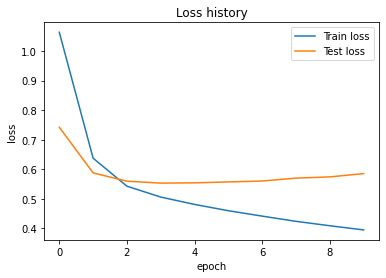


Accuracy = 74.23 %
* ROC AUC score = 0.82


In [ ]:
# -*- coding: utf-8 -*-
"""5-4.qqp(CNN).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1GkZhPT5ObWcTfXEQKIzyL7gWzzZ0rl3K
"""

# Quora question pairs : CNN 텍스트 유사도 모델
# --------------------------------------------
import numpy as np
from sklearn.model_selection  import train_test_split
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pickle

# Commented out IPython magic to ensure Python compatibility.
# %cd '/content/drive/My Drive/Colab Notebooks'

# 학습 데이터를 읽어온다.
with open('/content/drive/MyDrive/머신러닝/qqp.pkl', 'rb') as f:
    q1_data, q2_data, labels, word2idx = pickle.load(f)

# 학습 데이터와 시험 데이터로 나눈다.
trainQ1, testQ1, trainQ2, testQ2, trainY, testY = train_test_split(q1_data, q2_data, labels, test_size=0.2)

# CNN 모델을 빌드한다.
VOCAB_SIZE = np.max([q1_data, q2_data]) + 1
EMB_SIZE = 16
NUM_FILTER = 32
REGULARIZER = 0.005

# Question-1, 2 입력용
inputQ1 = Input(batch_shape=(None, trainQ1.shape[1]))
inputQ2 = Input(batch_shape=(None, trainQ2.shape[1]))

# shared embedding
sharedEmb = Embedding(VOCAB_SIZE, EMB_SIZE)

# Question-1 처리용 CNN
embQ1 = sharedEmb(inputQ1)
embQ1 = Dropout(rate=0.2)(embQ1)
convQ1 = Conv1D(filters=NUM_FILTER, kernel_size=3, activation='relu')(embQ1)
poolQ1 = GlobalMaxPool1D()(convQ1)
poolQ1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER))(poolQ1)
poolQ1 = Dropout(rate=0.2)(poolQ1)

# Question-2 처리용 CNN
embQ2 = sharedEmb(inputQ2)
embQ2 = Dropout(rate=0.2)(embQ2)
convQ2 = Conv1D(filters=NUM_FILTER, kernel_size=3, activation='relu')(embQ2)
poolQ2 = GlobalMaxPool1D()(convQ2)
poolQ2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER))(poolQ2)
poolQ2 = Dropout(rate=0.2)(poolQ2)

# Question-1, 2의 출력을 합쳐서 feed forward network으로 마무리 한다.
pool = Concatenate()([poolQ1, poolQ2])
hidden = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER))(pool)
hidden = Dropout(rate=0.2)(hidden)
outputY = Dense(1, activation='sigmoid')(hidden)

model = Model([inputQ1, inputQ2], outputY)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005))
model.summary()

trainQ1.shape

# 학습
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)
hist = model.fit([trainQ1, trainQ2], trainY,
                 validation_data = ([testQ1, testQ2], testY),
                 batch_size = 1024, epochs = 10)

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict([testQ1, testQ2])
predY = np.where(pred > 0.5, 1, 0)
accuracy = (testY == predY).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))
print("* ROC AUC score = %.2f" % (roc_auc_score(testY, pred)))